In [ ]:
!pip install torch torchvision tqdm
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 827.9 kB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [ ]:
image_size = 28

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/autism-data"

train_path = base_path + "/train"
test_path = base_path + "/test"
valid_path = base_path + "/valid"

In [ ]:
train_set = ImageFolder(
    root=train_path,
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)

In [ ]:
test_set = ImageFolder(
    root=test_path,
    transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

In [ ]:
valid_set = ImageFolder(
    root=valid_path,
    transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
N_WAY = 2  # no. of classes: autistic and non autistic
N_SHOT = 4  # no. of images per class
N_QUERY = 10  #  query set
N_EVALUATION_TASKS = 100

In [ ]:
print(test_set.samples)

def get_labels_function():
    return [label for _, label in test_set.samples]

test_set.get_labels = get_labels_function
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

[('/content/drive/MyDrive/autism-data/test/Autistic/001.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/003.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/004.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/005.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/006.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/007.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/008.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/009.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/010.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/011.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/012.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/013.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/014.jpg', 0), ('/content/drive/MyDrive/autism-data/test/Autistic/015.jpg', 0), ('/content/drive/MyDrive

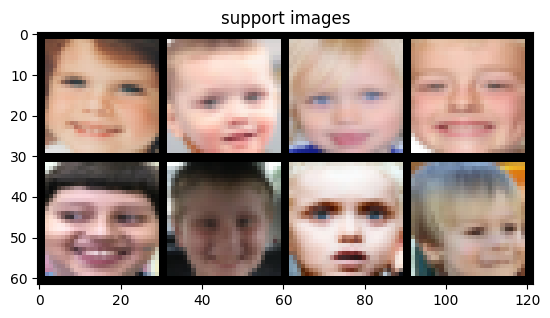

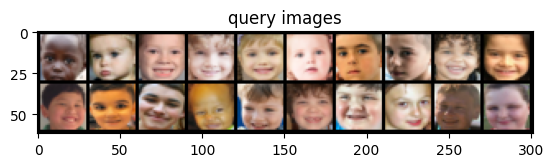

In [ ]:
(   example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set.samples[example_class_ids[example_query_labels[i]]]} / {test_set.samples[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) / ('/content/drive/MyDrive/autism-data/test/Autistic/001.jpg', 0)
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) / ('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0)
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) / ('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0)
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) / ('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0)
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) / ('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0)
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) / ('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0)
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) / ('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0)
('/content/drive/MyDrive/autism-data/test/Autistic/002.jpg', 0) /

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)

In [ ]:
def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [ ]:
evaluate(test_loader)

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]

Model tested on 100 tasks. Accuracy: 68.90%


In [ ]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

# Training set
train_set.get_labels = lambda: [instance[1] for instance in train_set.samples]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Validation set
valid_set.get_labels = lambda: [instance[1] for instance in valid_set.samples]
validation_sampler = TaskSampler(
    valid_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)
validation_loader = DataLoader(
    valid_set,
    batch_sampler=validation_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=validation_sampler.episodic_collate_fn,
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

 14%|█▍        | 5699/40000 [20:19<2:02:21,  4.67it/s, loss=0.702]


KeyboardInterrupt: ignored

In [ ]:
evaluate(test_loader)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Define a function to plot accuracy and loss curves
def plot_curves(train_values, val_values, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(train_values, label='Training')
    plt.plot(val_values, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Training loop
N_EPOCHS = 10  # Choose the number of epochs
log_update_frequency = 10
all_loss = []
all_accuracy = []

for epoch in range(N_EPOCHS):
    model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            loss_value = fit(support_images, support_labels, query_images, query_labels)
            all_loss.append(loss_value)

        if epoch % log_update_frequency == 0:
            # Evaluate on validation set
            val_accuracy = evaluate(validation_loader)
            all_accuracy.append(val_accuracy)
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency), accuracy=val_accuracy)

# Plot accuracy and loss curves
plot_curves(all_accuracy, sliding_average(all_loss, log_update_frequency), 'Accuracy and Loss Curves', 'Value')

# Evaluate on test set and plot confusion matrix
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm(enumerate(test_loader), total=len(test_loader)):
        _, predicted_labels = torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)
        y_true.extend(query_labels.numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

# Assuming your classes are binary (autistic and non-autistic)
class_labels = ['autistic', 'non-autistic']

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_labels)


  0%|          | 105/40000 [00:12<1:02:38, 10.62it/s]